In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob
from tqdm.notebook import tqdm, trange

"""Change to the data folder"""
new_path = "./new_train/new_train"

cuda_status = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [27]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)

### Create a loader to enable batch processing

In [28]:
import math

batch_sz = 64

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [np.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [np.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    scene_ids = [scene['scene_idx'] for scene in batch]
    track_ids = [scene['track_id'] for scene in batch]
    agent_ids = [scene['agent_id'] for scene in batch]
    car_mask = [scene['car_mask'] for scene in batch]
    
    inp = torch.FloatTensor(inp)
    out = torch.LongTensor(out)
    scene_ids = torch.LongTensor(scene_ids)
    car_mask = torch.LongTensor(car_mask)
    
    num_cars = np.zeros((inp.shape[0]))
    offsets = np.zeros((inp.shape[0], 2))
    
    real_input = np.zeros((inp.shape[0], 7, 19, 4))
    real_output = np.zeros((inp.shape[0], 7, 30, 2))
    
    for i in range(inp.shape[0]):
        
        num_vehicles = 0
        for j in range(60):
            if car_mask[i][j][0] == 1:
                num_vehicles += 1
        num_cars[i] = num_vehicles
        
        agent_id = agent_ids[i]
        vehicle_index = 0
        found = False
        while not found:
            if track_ids[i][vehicle_index][0][0] == agent_id:
                found = True
            else:
                vehicle_index += 1
        start_x = inp[i][vehicle_index][0][0]
        start_y = inp[i][vehicle_index][0][1]
        
        offsets[i][0] = start_x
        offsets[i][1] = start_y
        
        inp[i,0:num_vehicles,:,0] -= start_x
        inp[i,0:num_vehicles,:,1] -= start_y
        
        distances = [0] * num_vehicles
        for j in range(num_vehicles):
            if j == vehicle_index:
                continue
            distances[j] = math.sqrt(((inp[i,j,0,0] - inp[i,vehicle_index,0,0])**2) + ((inp[i,j,0,1] - inp[i,vehicle_index,0,1])**2))
        
        included = []
        for j in range(6):
            min_distance = -1
            min_index = -1
            
            for k in range(len(distances)):
                if k == vehicle_index:
                    continue
                
                if min_index == -1 and k not in included:
                    min_distance = distances[k]
                    min_index = k
                elif k not in included and distances[k] < min_distance:
                    min_distance = distances[k]
                    min_index = k
            if min_index == -1:
                real_input[i][j] = np.zeros((19,4))
                real_output[i][j] = np.zeros((30,2))
            else:
                included.append(min_index)
                real_input[i][j] = inp[i,min_index,:,:]
                real_output[i][j] = out[i,min_index,:,0:2]
        real_input[i][6] = inp[i,vehicle_index,:,:]
        real_output[i] = out[i,vehicle_index,:,0:2]
    
    real_input = torch.LongTensor(real_input)
    real_output = torch.LongTensor(real_output)
    offsets = torch.LongTensor(offsets)
    num_cars = torch.LongTensor(num_cars)
    return [real_input, real_output, scene_ids, offsets]

def test_collate(batch):
    inp = [np.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    scene_ids = [scene['scene_idx'] for scene in batch]
    track_ids = [scene['track_id'] for scene in batch]
    agent_ids = [scene['agent_id'] for scene in batch]
    car_mask = [scene['car_mask'] for scene in batch]
    
    inp = torch.FloatTensor(inp)
    #out = torch.LongTensor(out)
    scene_ids = torch.LongTensor(scene_ids)
    car_mask = torch.LongTensor(car_mask)
    
    num_cars = np.zeros((inp.shape[0]))
    offsets = np.zeros((inp.shape[0], 2))
    
    real_input = np.zeros((inp.shape[0], 7, 19, 4))
    real_output = np.zeros((inp.shape[0], 7, 30, 2))
    
    for i in range(inp.shape[0]):
        
        num_vehicles = 0
        for j in range(60):
            if car_mask[i][j][0] == 1:
                num_vehicles += 1
        num_cars[i] = num_vehicles
        
        agent_id = agent_ids[i]
        vehicle_index = 0
        found = False
        while not found:
            if track_ids[i][vehicle_index][0][0] == agent_id:
                found = True
            else:
                vehicle_index += 1
        start_x = inp[i][vehicle_index][0][0]
        start_y = inp[i][vehicle_index][0][1]
        
        offsets[i][0] = start_x
        offsets[i][1] = start_y
        
        inp[i,0:num_vehicles,:,0] -= start_x
        inp[i,0:num_vehicles,:,1] -= start_y
        
        distances = [0] * num_vehicles
        for j in range(num_vehicles):
            if j == vehicle_index:
                continue
            distances[j] = math.sqrt(((inp[i,j,0,0] - inp[i,vehicle_index,0,0])**2) + ((inp[i,j,0,1] - inp[i,vehicle_index,0,1])**2))
        
        included = []
        for j in range(6):
            min_distance = -1
            min_index = -1
            
            for k in range(len(distances)):
                if k == vehicle_index:
                    continue
                
                if min_index == -1 and k not in included:
                    min_distance = distances[k]
                    min_index = k
                elif k not in included and distances[k] < min_distance:
                    min_distance = distances[k]
                    min_index = k
            if min_index == -1:
                real_input[i][j] = np.zeros((19,4))
            else:
                included.append(min_index)
                real_input[i][j] = inp[i,min_index,:,:]
        real_input[i][6] = inp[i,vehicle_index,:,:]
    
    real_input = torch.LongTensor(real_input)
    offsets = torch.LongTensor(offsets)
    num_cars = torch.LongTensor(num_cars)
    return [real_input, scene_ids, offsets]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0, drop_last=True)

In [52]:
model = torch.nn.Sequential(
    torch.nn.Linear(76, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 60)
)
model.to(device)
if cuda_status:
    model = model.cuda()
print(sum(p.numel() for p in model.parameters()))

12988


### Visualize the batch of sequences

In [34]:
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

agent_id = 0
epoch = 3

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out, scene_ids, track_ids, agent_ids = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])
        
# Use the nn package to define our loss function
loss_fn=torch.nn.MSELoss()

# Use the optim package to define an Optimizer

learning_rate =1e-3
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epoch_count = 0

for i in trange(epoch):
    iterator = tqdm(val_loader)
    total = 0
    count = 0
    
    for i_batch, sample_batch in enumerate(iterator):
        inp, out, scene_ids, offsets = sample_batch
        """TODO:
          Deep learning model
          training routine
        """
        
        x = torch.flatten(inp, start_dim=2)

        x = x.float()
        y = out.float()

        if cuda_status:
            #model = model.cuda()
            #x = inp.cuda()
            #y = out.cuda()
            x.to(device)
            y.to(device)
            x = x.cuda()
            y = y.cuda()

        y_pred = None

        # Forward pass: predict y by passing x to the model.    
        y_pred = model(x)
        y_pred = torch.reshape(y_pred, torch.Size([batch_sz, 7, 30, 2]))
        
        for i in range(y_pred.shape[0]):
            y_pred[i,:,:,0] += offsets[i][0]
            y_pred[i,:,:,1] += offsets[i][1]

        # Compute the loss.
        loss = loss_fn(y_pred[:,6,:,:], y[:,6,:,:])
        total += torch.sqrt(loss).item()

        # Before backward pass, zero outgradients to clear buffers  
        optimizer.zero_grad()

        # Backward pass: compute gradient w.r.t modelparameters
        loss.backward()

        # makes an gradient descent step to update its parameters
        optimizer.step()
        
        count += 1
        
        #print(torch.sqrt(loss).item(), end='\r')
        iterator.set_postfix(loss=total / count, curr=torch.sqrt(loss).item())
    
    epoch_count += 1
    torch.save(model, './models/new-linear4' + str(epoch_count) + '.pt')


In [ ]:
torch.save(model, './models/3epochlinearreoriented.pt')

In [30]:
model = torch.load('./models/new-linear33.pt')
model.eval()
model.to(device)
if cuda_status:
    model = model.cuda()

torch.Size([64, 7, 19, 4])


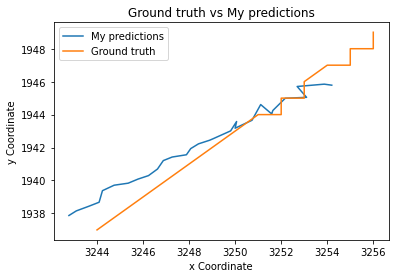

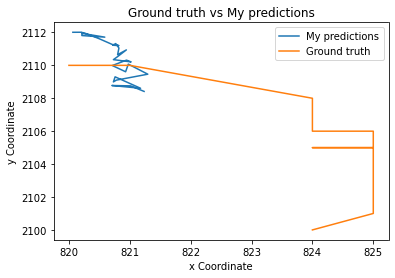

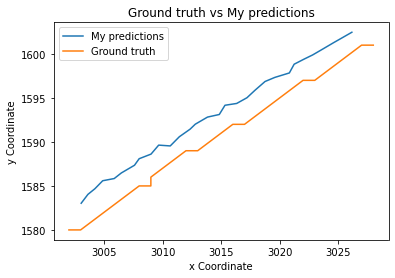

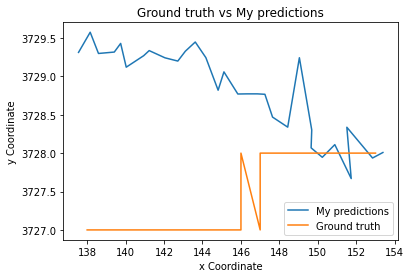

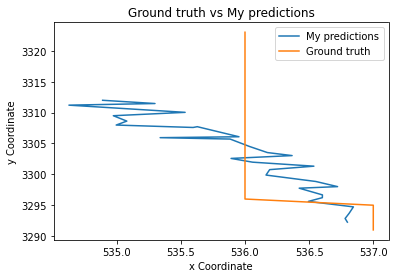

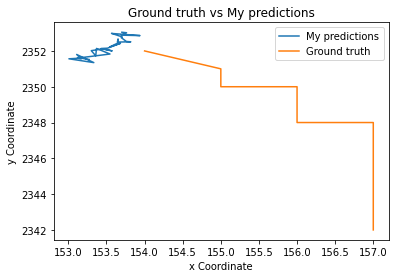

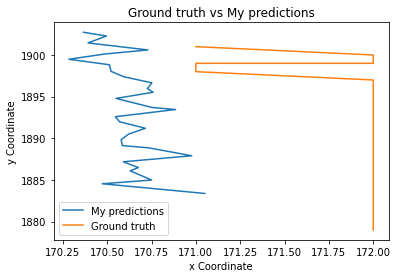

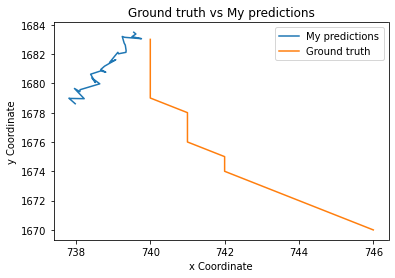

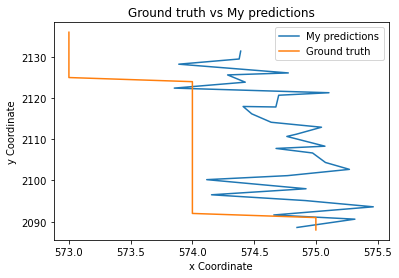

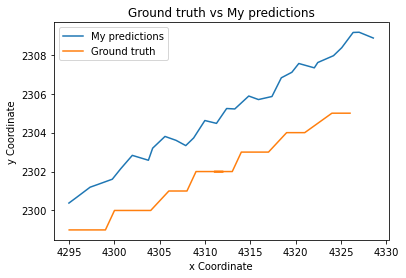

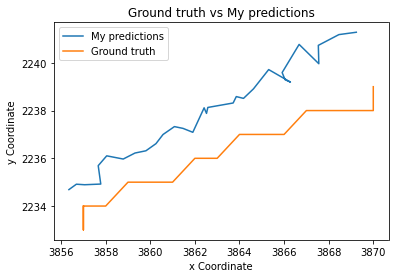

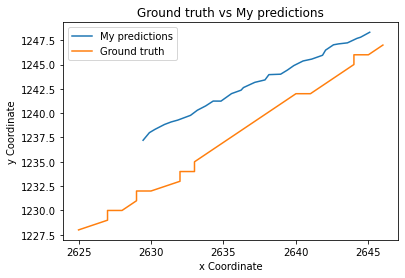

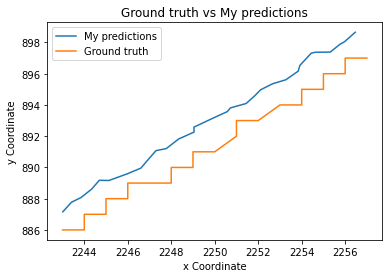

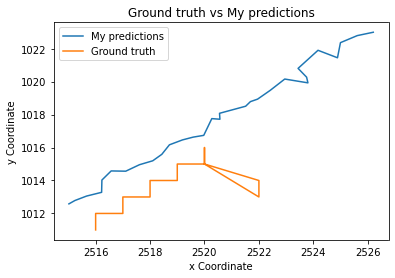

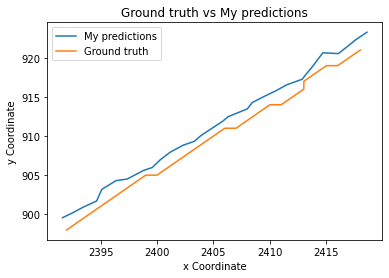

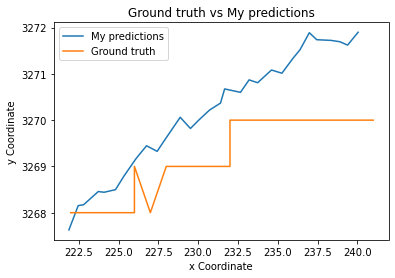

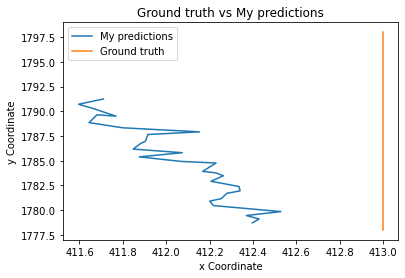

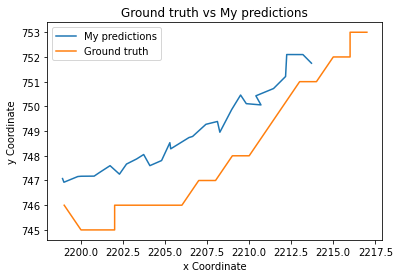

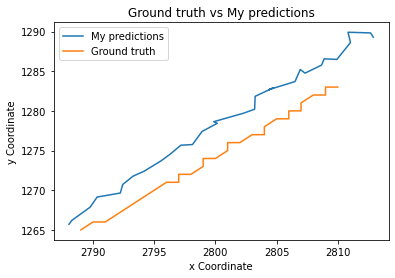

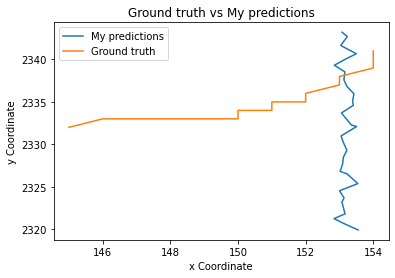

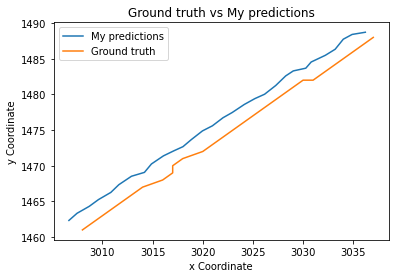

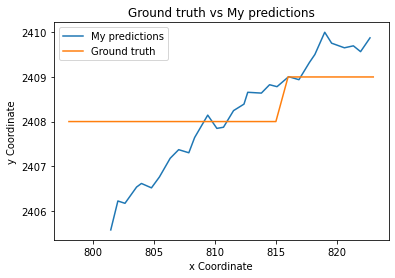

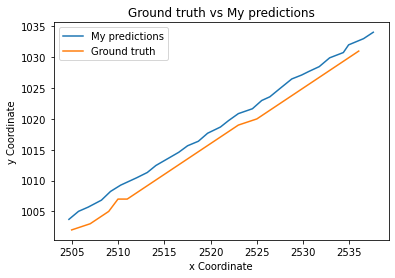

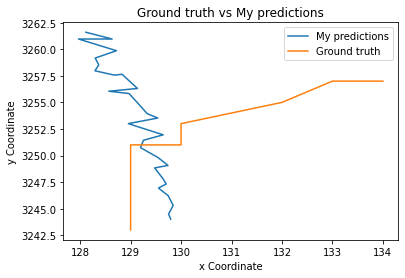

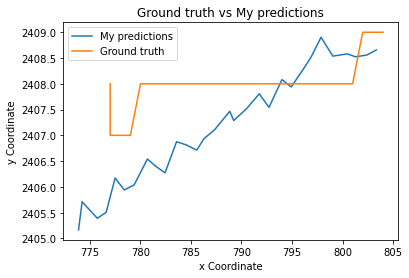

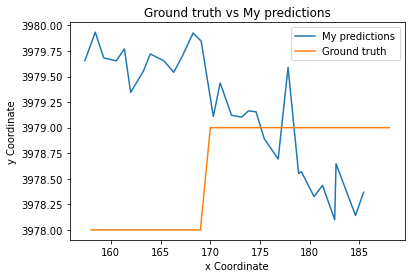

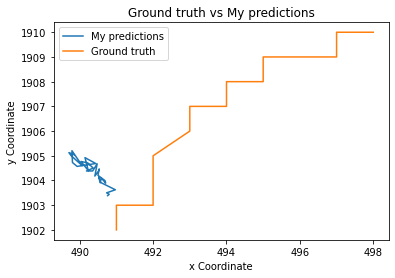

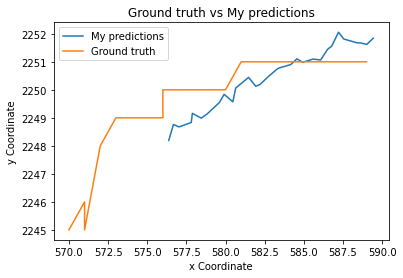

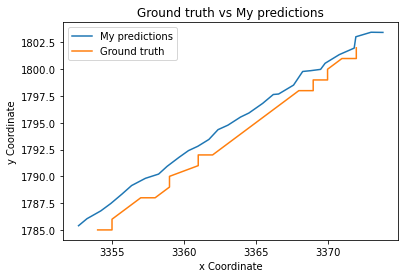

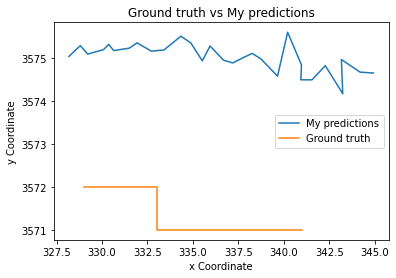

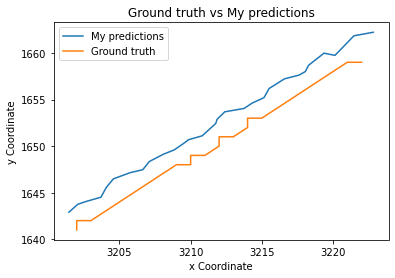

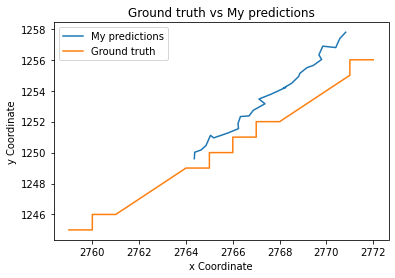

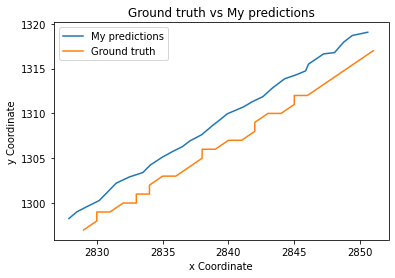

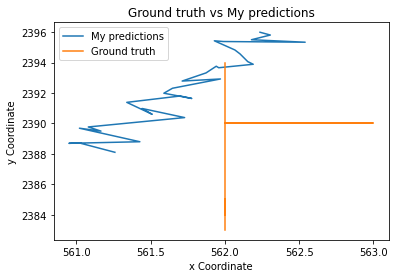

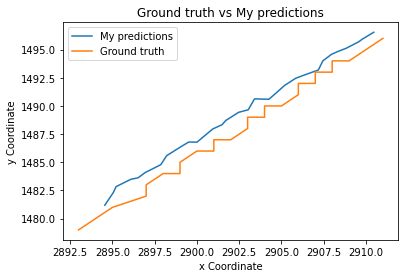

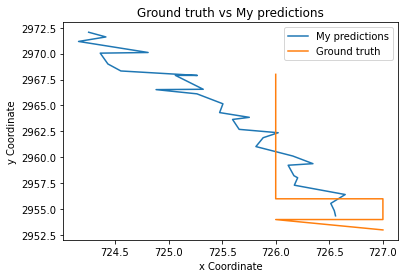

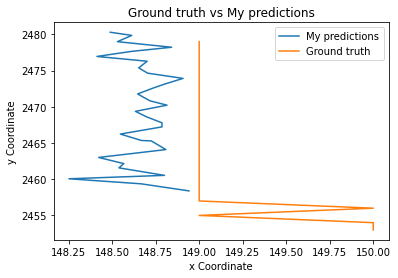

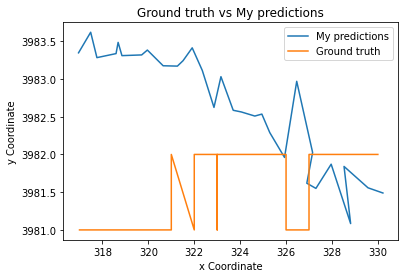

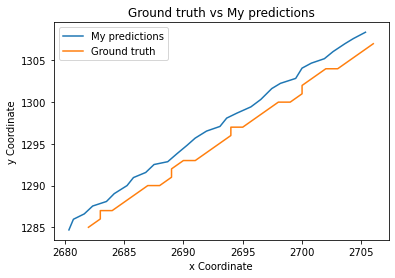

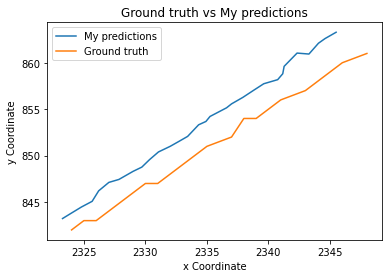

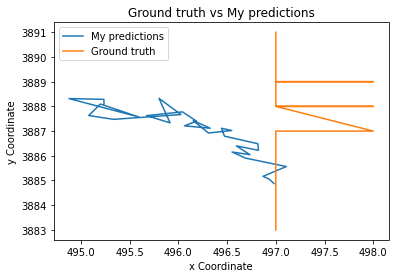

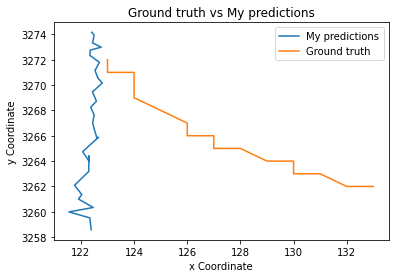

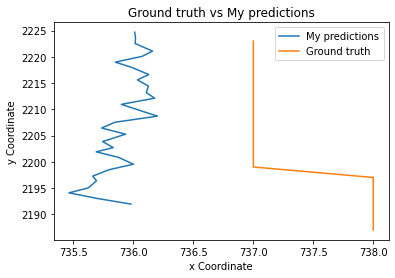

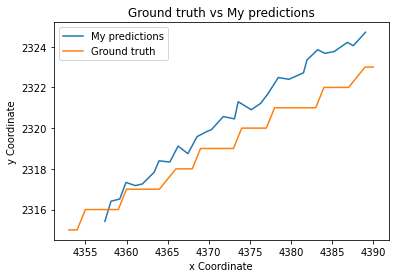

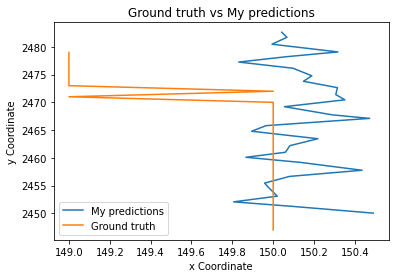

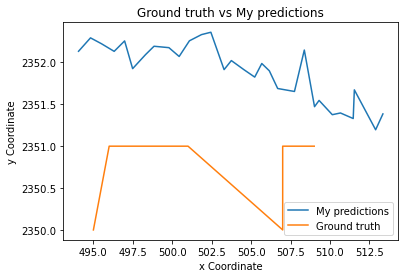

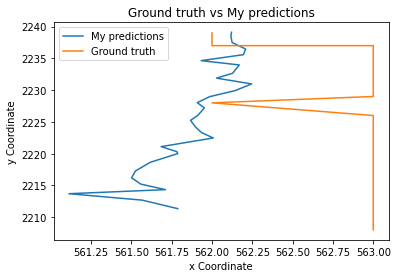

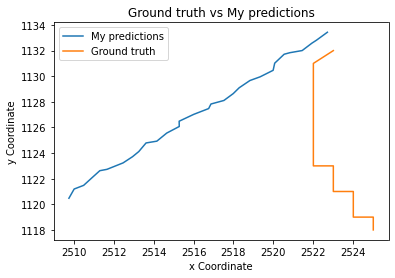

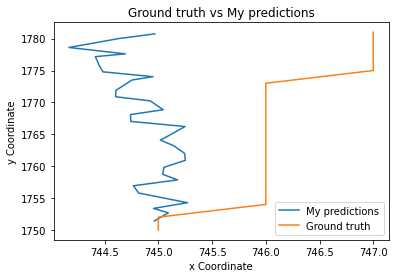

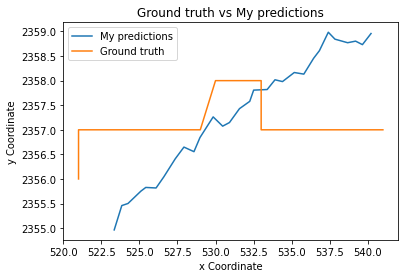

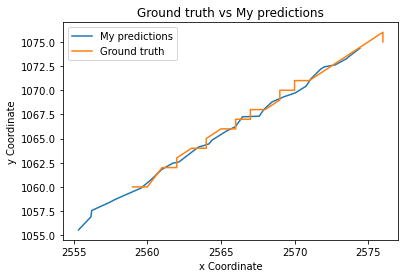

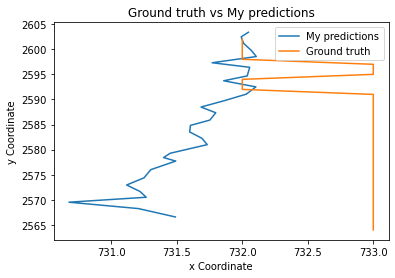

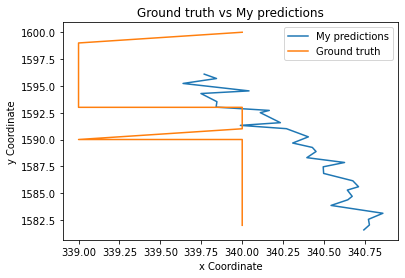

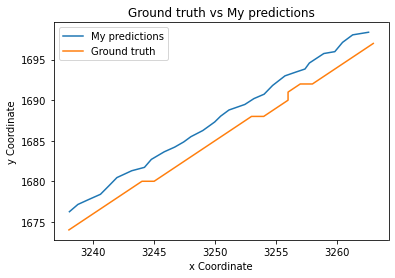

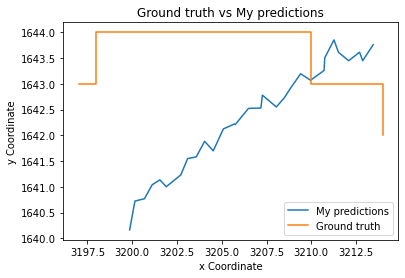

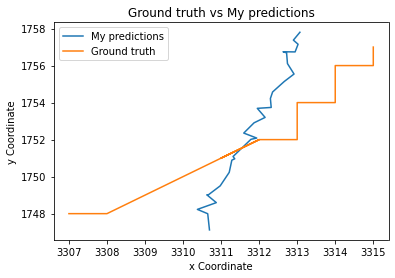

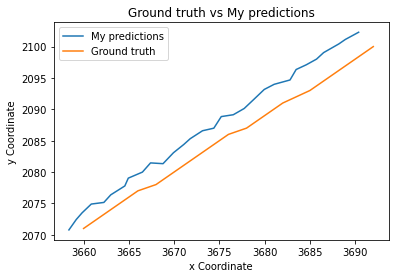

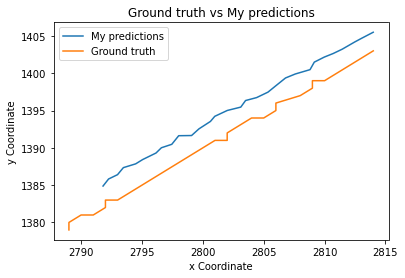

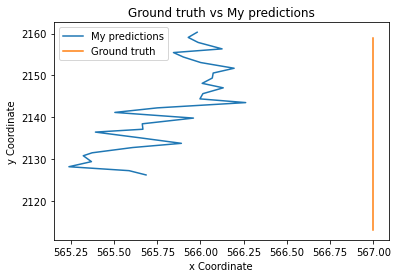

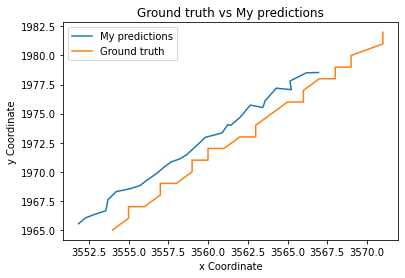

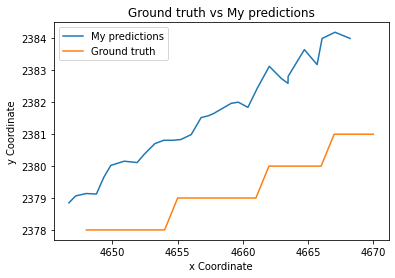

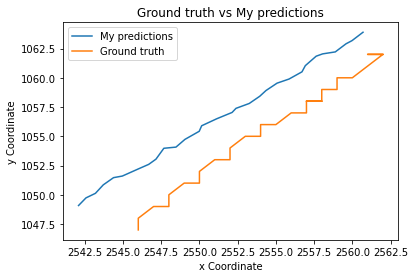

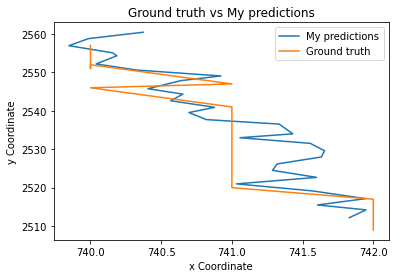

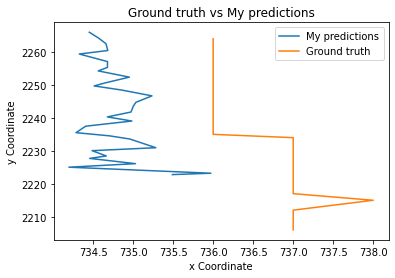

In [51]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out, scene_ids, offsets = sample_batch

        x = torch.flatten(inp, start_dim=2)

        if cuda_status:
            model = model.cuda()
            x = x.cuda()
        else:
            x = x

        y_pred = None

        # Forward pass: predict y by passing x to the model.    
        y_pred = model(x.float())
        y_pred = torch.reshape(y_pred, torch.Size([batch_sz, 7, 30, 2]))
        
        for i in range(y_pred.shape[0]):
            #inp[i,:,:,0] += offsets[i][0]
            #inp[i,:,:,1] += offsets[i][1]
            y_pred[i,:,:,0] += offsets[i][0]
            y_pred[i,:,:,1] += offsets[i][1]

        print(inp.shape)
        for j in range(64):
            curr_in = inp[j,6,:,0:2]
            my_out = y_pred[j,6,:,0:2]
            curr_out = out[j,6,:,0:2]
            
            my_x = []
            my_y = []
            out_x = []
            out_y = []
            in_x = []
            in_y = []
            for i in range(30):
                if i < 19:
                    in_x.append(curr_in[i][0].item())
                    in_y.append(curr_in[i][1].item())
                my_x.append(my_out[i][0].item())
                my_y.append(my_out[i][1].item())
                out_x.append(curr_out[i][0].item())
                out_y.append(curr_out[i][1].item())
            #plt.plot(in_x, in_y)
            plt.plot(my_x, my_y)
            #print(list(zip(my_x,my_y)))
            #print(list(zip(out_x, out_y)))
            plt.plot(out_x, out_y)
            plt.legend(['My predictions', 'Ground truth'])
            plt.xlabel('x Coordinate')
            plt.ylabel('y Coordinate') 
            plt.title('Ground truth vs My predictions')
            #break
            plt.show()
            

        break

In [37]:
import pandas as pd

# Submission output
writeCSV = True
val_path = "./new_val_in/new_val_in"

if writeCSV:
    
    dataset = ArgoverseDataset(data_path=val_path)
    test_loader = DataLoader(dataset,batch_size=64, shuffle = False, collate_fn=test_collate, num_workers=0)
    
    data = []
    
    with torch.no_grad():
        for i_batch, sample_batch in enumerate(tqdm(test_loader)):
            inp, scene_ids, offsets = sample_batch
            inp = torch.flatten(inp, start_dim=2)

            if cuda_status:
                model = model.cuda()
                x = inp.cuda()
            else:
                x = inp

            y_pred = None

            # Forward pass: predict y by passing x to the model.    
            y_pred = model(x.float())
            y_pred = torch.reshape(y_pred, torch.Size([64, 7, 30, 2]))
            
            for i in range(y_pred.shape[0]):
                y_pred[i,:,:,0] += offsets[i][0]
                y_pred[i,:,:,1] += offsets[i][1]
            
            for i in range(64):
                row = []
                row.append(scene_ids[i].item())
                
                curr = y_pred[i]
                
                for j in range(30):
                    row.append(str(curr[6][j][0].item()))
                    row.append(str(curr[6][j][1].item()))
                    
                data.append(row)

    df = pd.DataFrame(data, columns = ['ID','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16','v17','v18','v19','v20','v21','v22','v23','v24','v25','v26','v27','v28','v29','v30','v31','v32','v33','v34','v35','v36','v37','v38','v39','v40','v41','v42','v43','v44','v45','v46','v47','v48','v49','v50','v51','v52','v53','v54','v55','v56','v57','v58','v59','v60'])
    print(df)
    df.to_csv('submission.csv', index=False)
                
                
                


         ID                  v1                  v2                  v3  \
0     10002  1714.4383544921875   337.1763000488281  1714.9471435546875   
1     10015   724.5989990234375  1230.5294189453125   724.5674438476562   
2     10019    572.957763671875  1245.2320556640625    573.118408203125   
3     10028  1692.3201904296875   316.8569641113281  1692.7969970703125   
4      1003      2120.248046875   677.7117919921875     2118.8779296875   
...     ...                 ...                 ...                 ...   
3195   9897  255.21475219726562   806.3004150390625  255.34490966796875   
3196     99         586.5859375       1154.57421875   586.5447387695312   
3197   9905    1755.14111328125   443.8507995605469   1754.610107421875   
3198   9910     573.93994140625   1288.857177734375     573.88916015625   
3199   9918   582.8952026367188   1165.745849609375   582.8462524414062   

                      v4                  v5                  v6  \
0      337.6438293457031  1716